## RQ5: How do the growth and dynamics of the Airbnb market in London influence guest sentiments in apartment-type accommodations?


- Market Growth Impact: How the increase in the number of listings, changes in pricing, and occupancy rates correlate with guest sentiments. 

- Identifying Key Influences: Determine if significant events or market dynamics (like price surges, availability changes) have a notable impact on guest sentiments.

**Visualisation**
1. Time-Series Line charts
- Seniment Scores Over Time
- Listings and price trends
2. Seasonal Analysis
3. Event Impact Analysis

In [45]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Load the datasets
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')
calendar_df = pd.read_csv('calendar.csv', low_memory=False)

In [14]:
# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)


In [25]:
# Convert sentiment categories to numerical scores
def sentiment_to_score(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return -1
    else:
        return 0

language_custom_2['sentiment_score'] = language_custom_2['sentiment'].apply(sentiment_to_score)

# Convert date column to datetime
language_custom_2['date'] = pd.to_datetime(language_custom_2['date'])

# Define the periods for segmentation
periods = {
    'Pre-Brexit': (language_custom_2['date'].min(), '2015-01'),
    'During Brexit': ('2015-01', '2016-06'),
    'Pre-COVID': (language_custom_2['date'].min(), '2020-02'),
    'During COVID': ('2020-02', '2021-06'),
    'Post-COVID': ('2021-06', language_custom_2['date'].max())
}

# Function to assign period based on date
def assign_period(date):
    for period, (start, end) in periods.items():
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return period
    return 'unknown'

language_custom_2['period'] = language_custom_2['date'].apply(assign_period)

# Group by date and calculate the mean sentiment score
sentiment_over_time = language_custom_2.groupby('date')['sentiment_score'].mean().reset_index()


In [26]:
# Ensure there are no infinities or NaNs in the data
sentiment_over_time = sentiment_over_time.replace([np.inf, -np.inf], np.nan).dropna()

# Verify data types and values
print(sentiment_over_time.dtypes)
print(sentiment_over_time.head())

date               datetime64[ns]
sentiment_score           float64
dtype: object
        date  sentiment_score
0 2010-12-29              1.0
1 2011-03-05              1.0
2 2011-03-09              1.0
3 2011-03-18              1.0
4 2011-03-21              1.0


            sentiment_score
date                       
2010-12-29              1.0
2011-03-05              1.0
2011-03-09              1.0
2011-03-18              1.0
2011-03-21              1.0


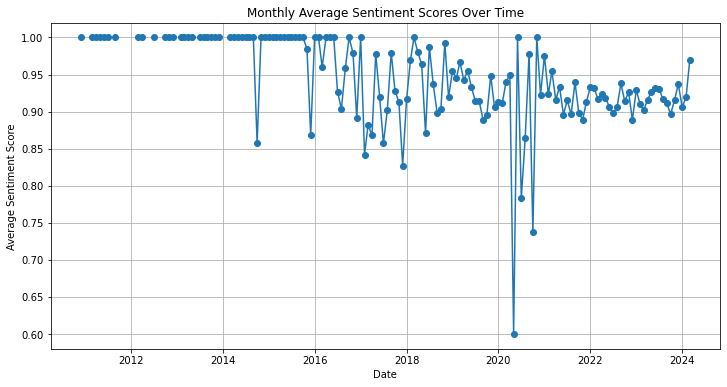

In [33]:
# Verify the columns before setting the index
print(sentiment_over_time.head())

sentiment_monthly = sentiment_over_time.resample('MS').mean().reset_index()

# Plot the monthly average sentiment scores over time using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(sentiment_monthly['date'].values, sentiment_monthly['sentiment_score'].values, marker='o')
plt.title('Monthly Average Sentiment Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

**Time-Series Line Charts:**

- Sentiment Scores Over Time: Use line charts to show the average sentiment scores over time. This helps in identifying trends and patterns in guest sentiments across different periods.

- Listings and Price Trends: Line charts can also be used to show the growth in the number of listings and changes in average prices over time.

## Analyse the Increase in the Number of Listings and Analyse Changes in Pricing

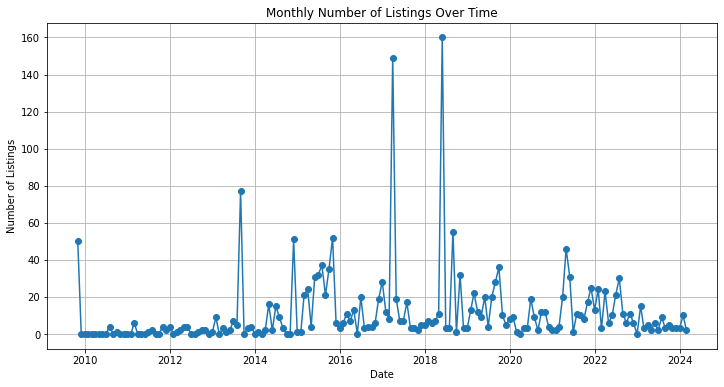

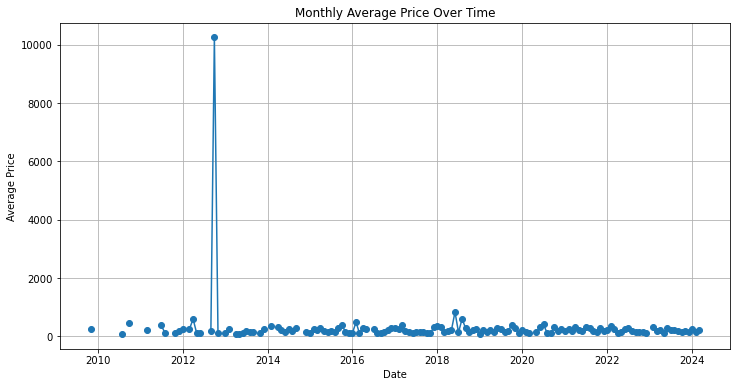

In [37]:
# Convert date column to datetime in listings_df
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

# Convert price column to numeric
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Group by date to get the number of listings and average price over time
listings_over_time = listings_df.groupby('host_since').agg({'listing_id': 'count', 'price': 'mean'}).reset_index()
listings_over_time.rename(columns={'host_since': 'date', 'listing_id': 'num_listings'}, inplace=True)

# Ensure there are no infinities or NaNs in the data
listings_over_time = listings_over_time.replace([np.inf, -np.inf], np.nan).dropna()

# Resample the data by month to match the sentiment analysis
listings_over_time.set_index('date', inplace=True)
listings_monthly = listings_over_time.resample('MS').agg({'num_listings': 'sum', 'price': 'mean'}).reset_index()

# Plot the number of listings over time using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(listings_monthly['date'].values, listings_monthly['num_listings'].values, marker='o')
plt.title('Monthly Number of Listings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.grid(True)
plt.show()

# Plot the average price over time using matplotlib
plt.figure(figsize=(12, 6))
plt.plot(listings_monthly['date'].values, listings_monthly['price'].values, marker='o')
plt.title('Monthly Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


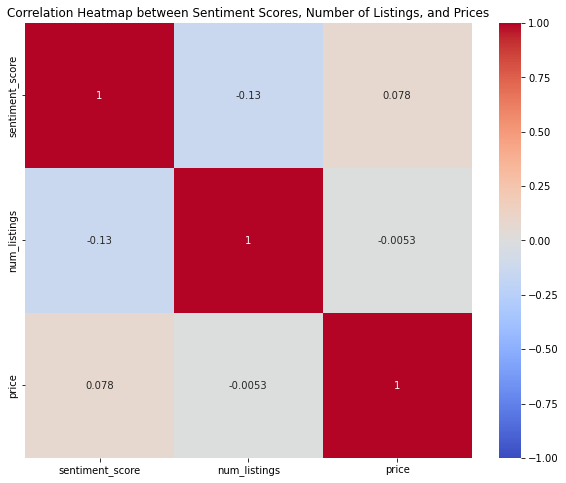

In [39]:
# Group by date and calculate the mean sentiment score
sentiment_over_time = language_custom_2.groupby('date')['sentiment_score'].mean().reset_index()

# Ensure there are no infinities or NaNs in the data
sentiment_over_time = sentiment_over_time.replace([np.inf, -np.inf], np.nan).dropna()

# Resample the data by month and calculate the mean sentiment score
sentiment_over_time.set_index('date', inplace=True)
sentiment_monthly = sentiment_over_time.resample('MS').mean().reset_index()

# Convert date column to datetime in listings_df
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

# Convert price column to numeric
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Group by date to get the number of listings and average price over time
listings_over_time = listings_df.groupby('host_since').agg({'listing_id': 'count', 'price': 'mean'}).reset_index()
listings_over_time.rename(columns={'host_since': 'date', 'listing_id': 'num_listings'}, inplace=True)

# Ensure there are no infinities or NaNs in the data
listings_over_time = listings_over_time.replace([np.inf, -np.inf], np.nan).dropna()

# Resample the data by month to match the sentiment analysis
listings_over_time.set_index('date', inplace=True)
listings_monthly = listings_over_time.resample('MS').agg({'num_listings': 'sum', 'price': 'mean'}).reset_index()

# Merge the dataframes on the date column
merged_data = pd.merge(sentiment_monthly, listings_monthly, on='date', how='inner')

# Calculate the correlation matrix
correlation_matrix = merged_data[['sentiment_score', 'num_listings', 'price']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Sentiment Scores, Number of Listings, and Prices')
plt.show()

**Summary**

- The correlations are generally weak, indicating that sentiment scores, the number of listings, and prices are not strongly interrelated in the dataset.

- The weak negative correlation between sentiment scores and the number of listings suggests that an increase in the number of listings might slightly decrease sentiment scores, but the effect is minimal.

- The weak positive correlation between sentiment scores and prices suggests that higher prices might slightly improve sentiment scores, but this effect is also minimal.

- The number of listings and prices are almost entirely uncorrelated, suggesting that changes in one do not significantly affect the other.

### Analyse Occupancy Rates

In [40]:
# Convert date columns to datetime
language_custom_2['date'] = pd.to_datetime(language_custom_2['date'])
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

# Convert price column to numeric
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Calculate sentiment scores by month
sentiment_over_time = language_custom_2.groupby('date')['sentiment_score'].mean().reset_index()
sentiment_over_time.set_index('date', inplace=True)
sentiment_monthly = sentiment_over_time.resample('MS').mean().reset_index()

# Calculate number of listings and average price by month
listings_over_time = listings_df.groupby('host_since').agg({
    'listing_id': 'count',
    'price': 'mean',
    'availability_30': 'mean',
    'availability_60': 'mean',
    'availability_90': 'mean',
    'availability_365': 'mean'
}).reset_index()
listings_over_time.rename(columns={'host_since': 'date', 'listing_id': 'num_listings'}, inplace=True)
listings_over_time.set_index('date', inplace=True)
listings_monthly = listings_over_time.resample('MS').mean().reset_index()

# Merge sentiment and listings data
merged_data = pd.merge(sentiment_monthly, listings_monthly, on='date', how='inner')

# Calculate estimated occupancy rates as 1 - (average availability / total days)
merged_data['occupancy_rate_30'] = 1 - (merged_data['availability_30'] / 30)
merged_data['occupancy_rate_60'] = 1 - (merged_data['availability_60'] / 60)
merged_data['occupancy_rate_90'] = 1 - (merged_data['availability_90'] / 90)
merged_data['occupancy_rate_365'] = 1 - (merged_data['availability_365'] / 365)

*Remark: Definition*

- A higher 'availability_30' value indicates that the property is less booked and has more open days available for potential guests. Conversely, a lower 'availability_30' value means that the property is more booked and has fewer available days in the next 30 days.

- A higher 'occupancy_rate_30' indicates that the property is frequently booked and has high demand in the upcoming month. A lower 'occupancy_rate_30' suggests lower demand and more available days for booking.


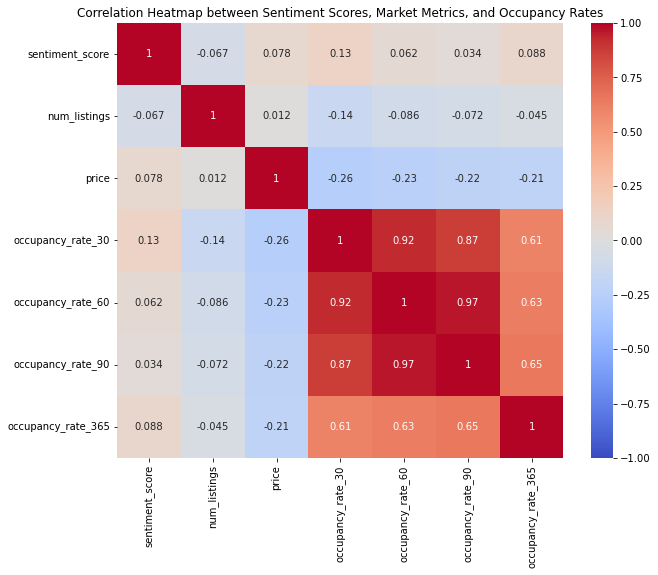

In [41]:
# Calculate the correlation matrix
correlation_matrix = merged_data[['sentiment_score', 'num_listings', 'price', 'occupancy_rate_30', 'occupancy_rate_60', 'occupancy_rate_90', 'occupancy_rate_365']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Sentiment Scores, Market Metrics, and Occupancy Rates')
plt.show()

### Summary

- Sentiment Scores: They are weakly related to the number of listings, prices, and occupancy rates. The slight negative correlation with the number of listings suggests that as the market grows, guest satisfaction might slightly decrease.

- Market Dynamics: Prices and occupancy rates show a more noticeable relationship. Higher prices are moderately associated with lower occupancy rates, indicating that more expensive properties may not be as frequently booked.

- Occupancy Rates: Different occupancy metrics are highly correlated with each other, reflecting their interconnected nature.

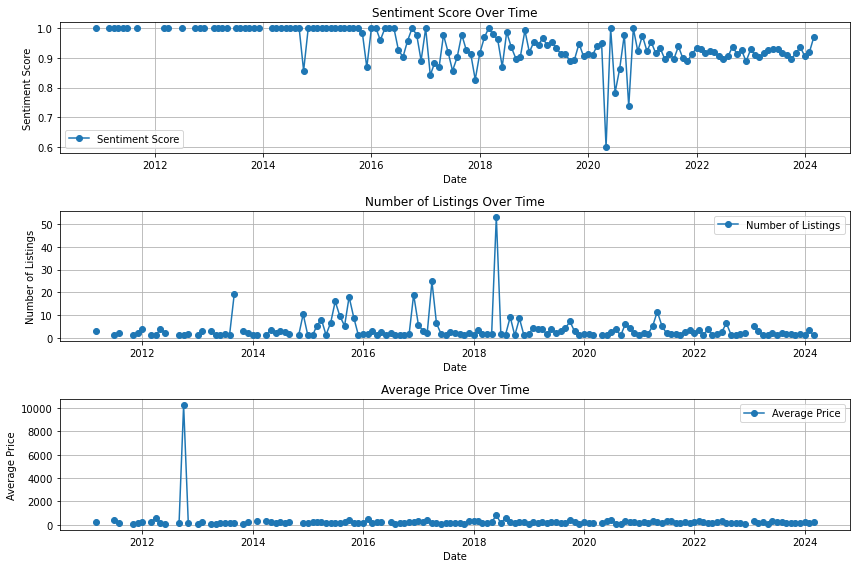

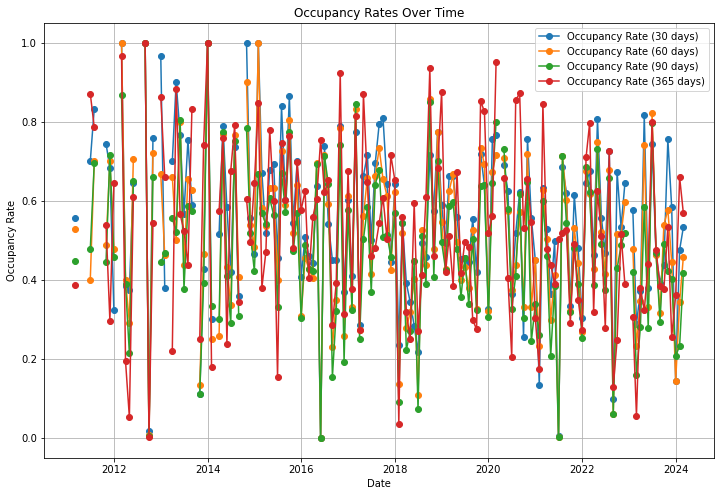

In [44]:
# Convert DataFrame columns to numpy arrays
dates = merged_data['date'].values
sentiment_scores = merged_data['sentiment_score'].values
num_listings = merged_data['num_listings'].values
prices = merged_data['price'].values
occupancy_rate_30 = merged_data['occupancy_rate_30'].values
occupancy_rate_60 = merged_data['occupancy_rate_60'].values
occupancy_rate_90 = merged_data['occupancy_rate_90'].values
occupancy_rate_365 = merged_data['occupancy_rate_365'].values

# Plot trends over time in separate plots
plt.figure(figsize=(12, 8))

# Sentiment Score
plt.subplot(3, 1, 1)
plt.plot(dates, sentiment_scores, marker='o', label='Sentiment Score')
plt.legend()
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.grid(True)

# Number of Listings
plt.subplot(3, 1, 2)
plt.plot(dates, num_listings, marker='o', label='Number of Listings')
plt.legend()
plt.title('Number of Listings Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Listings')
plt.grid(True)

# Average Price
plt.subplot(3, 1, 3)
plt.plot(dates, prices, marker='o', label='Average Price')
plt.legend()
plt.title('Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot occupancy rates separately
plt.figure(figsize=(12, 8))

plt.plot(dates, occupancy_rate_30, marker='o', label='Occupancy Rate (30 days)')
plt.plot(dates, occupancy_rate_60, marker='o', label='Occupancy Rate (60 days)')
plt.plot(dates, occupancy_rate_90, marker='o', label='Occupancy Rate (90 days)')
plt.plot(dates, occupancy_rate_365, marker='o', label='Occupancy Rate (365 days)')
plt.legend()
plt.title('Occupancy Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Occupancy Rate')
plt.grid(True)

plt.show()

### Summary of the occupancy over time

**Occupancy Rate Trends:**

- The occupancy rates fluctuate significantly over time for all periods.
- The occupancy rates generally range between 0 and 1, with some periods showing higher variability than others.

**High Variability:**

- There is noticeable variability in occupancy rates, indicating that the availability of listings changes frequently.
- This could be due to various factors such as seasonal demand, market dynamics, and external events impacting bookings.

**Short-Term vs. Long-Term Occupancy:**

- The shorter-term occupancy rates (30 days, 60 days) show more frequent and pronounced fluctuations compared to the longer-term occupancy rates (90 days, 365 days).

- This suggests that short-term availability is more volatile, possibly due to short-term rentals being more sensitive to immediate market conditions and booking patterns.

**Period-Specific Observations:**

- 2012 Spike: There is a notable spike around 2012, which might be an anomaly or an event-driven change in the market.

- Pre-COVID Period: From 2018 to early 2020, occupancy rates show significant fluctuations, possibly reflecting normal market dynamics.

- During COVID: From early 2020 onwards, there are visible fluctuations in occupancy rates, which could be influenced by the COVID-19 pandemic affecting travel and booking patterns.

**Summary**

- **Volatility:** The high volatility in occupancy rates suggests a dynamic market where the availability of listings can change rapidly.

- **Short-Term Sensitivity:** Short-term occupancy rates are more sensitive to immediate changes, while long-term rates show more stability.

- **External Factors:** Events like the 2012 spike and the COVID-19 pandemic seem to impact occupancy rates significantly, reflecting broader market and social changes.


### Summary of comparative analysis

**Sentiment and Listings:**

The drop in sentiment scores around 2018 coincides with a spike in the number of listings. This suggests that the sudden increase in listings may have impacted guest satisfaction negatively, possibly due to lower quality control or newer hosts being less experienced.

**Sentiment and Price:**

There is no clear direct correlation between the average price and sentiment scores from this visual inspection. However, significant price spikes do not seem to correspond directly to drops in sentiment scores.

**Listings and Price:**

The spikes in the number of listings and the average price around 2018 may indicate a market anomaly or an external event affecting both metrics simultaneously.

## Seasonal Analysis

- use **decomposition** of the time series to interpret.

/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_14161/2151154267.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_sentiment['sentiment_score'].fillna(method='ffill', inplace=True)
/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_14161/2151154267.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_sentiment['sentiment_score'].fillna(method='ffill', inplace=True)


<Figure size 864x576 with 0 Axes>

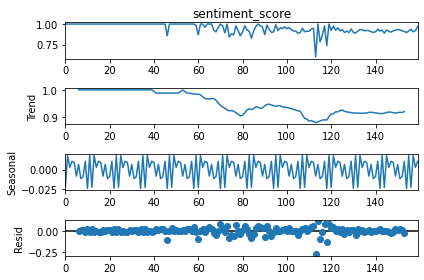

In [52]:
# Ensure there are no missing values
monthly_sentiment['sentiment_score'].fillna(method='ffill', inplace=True)
# Decompose the time series for sentiment scores
result = seasonal_decompose(sentiment_monthly['sentiment_score'], model='additive', period=12)

# Plot the decomposition results
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

**Overall Interpretation:**

- Trend Decline: There has been a notable decline in sentiment scores over time, but with signs of stabilization or recovery.

- Seasonal Fluctuations: There are regular, periodic fluctuations in sentiment scores, suggesting that certain times of the year may consistently affect guest sentiments.

- Residuals: The residual component does not show strong patterns, indicating that the model has appropriately captured the main trend and seasonality in the data.

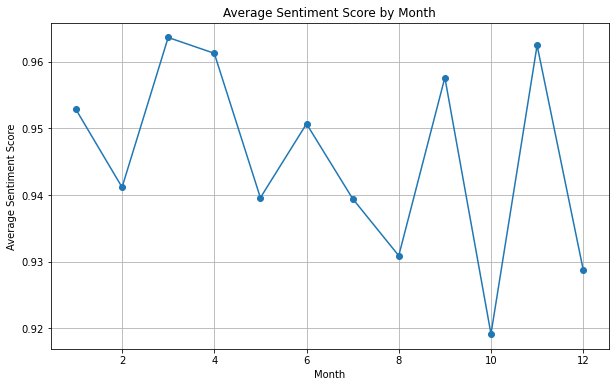

In [55]:
# Add a 'month' column to the data
merged_data['month'] = merged_data['date'].dt.month

# Group by month and calculate the mean sentiment score
monthly_sentiment = merged_data.groupby('month')['sentiment_score'].mean().reset_index()

# Ensure there are no missing values
monthly_sentiment['sentiment_score'] = monthly_sentiment['sentiment_score'].ffill().bfill()

# Plot the average sentiment score by month using Matplotlib directly
plt.figure(figsize=(10, 6))
plt.plot(monthly_sentiment['month'].values, monthly_sentiment['sentiment_score'].values, marker='o')
plt.title('Average Sentiment Score by Month')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

**Seasonal Trends:**

- The seasonal component of the sentiment scores suggests that certain months consistently show higher or lower sentiment scores. 

- For instance, the increase in sentiment scores in March, May, June, and November could be attributed to favorable weather, holidays, or events that enhance the guest experience.

- Conversely, the lower scores in February, August, October, and December might be due to adverse weather conditions, high tourist congestion, or other factors that negatively impact guest satisfaction.

**Potential Influences:**

- Weather: Weather conditions can significantly impact travel experiences. Pleasant weather in certain months could lead to higher sentiment scores.

- Events and Holidays: Major events, festivals, or holidays can attract more tourists and enhance their experiences, reflected in higher sentiment scores.

- Tourist Congestion: High tourist seasons might lead to overcrowding, affecting the quality of stay and resulting in lower sentiment scores.

- Service Quality Variations: Variations in service quality or availability of amenities during different times of the year could also influence sentiment scores.

**Contextual Analysis**

**Weather:**

- March to June: Spring season in London with generally mild and pleasant weather, likely contributing to higher sentiment scores. Tourists can enjoy outdoor activities and sightseeing without the extremes of summer or winter.

- November: Autumn in London can be quite picturesque with mild weather, fewer tourists compared to the peak summer months, and various cultural events like Bonfire Night.

- February: Winter in London can be cold and dreary, potentially contributing to lower sentiment scores as guests might face weather-related inconveniences.

- August: Summer in London sees a peak in tourism, which can lead to overcrowding, higher prices, and potentially strained services, all contributing to lower sentiment scores.

- October and December: The transition to colder weather and the busy holiday season might lead to a mix of service-related issues and weather-related discomforts affecting guest satisfaction.

**Events and Holidays:**

**Higher Sentiment Periods:**

- Spring Festivals: Events like the Chelsea Flower Show (May) attract tourists and offer unique experiences.

- Autumn Events: Cultural events and less crowded tourist spots in November can enhance guest experiences.

**Lower Sentiment Periods:**

- Winter Months: Cold weather, shorter daylight hours, and fewer outdoor activities might detract from the overall experience.

- Peak Tourist Season: August sees an influx of tourists, which can overwhelm the local infrastructure and services, leading to lower satisfaction.

### Strategic Recommendations:

**Enhancing Guest Experience During Low Sentiment Periods:**

- February: Offer indoor activities, discounts, and packages that include weather-appropriate amenities to mitigate the impact of cold weather.

- August: Improve service efficiency to handle peak crowds, offer early booking discounts, and provide clear information about popular tourist spots to manage expectations and enhance experiences.

- October and December: Emphasize holiday-themed experiences, provide extra amenities to counter the cold, and ensure high-quality service during the busy holiday season.

**Leveraging High Sentiment Periods:**

- March to June: Promote these months as the best times to visit London with special offers and highlight outdoor attractions and events.

- November: Focus on cultural and seasonal events to attract more guests and enhance their experiences.

**Continuous Monitoring and Feedback:**

- Regularly monitor guest feedback and sentiment scores to identify emerging trends or issues.

- Use guest feedback to make real-time adjustments to services and amenities to maintain high levels of satisfaction throughout the year.

## Event Impact Analysis

/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_14161/2744250185.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sentiment_monthly['sentiment_score'].fillna(method='ffill', inplace=True)
/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_14161/2744250185.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_monthly['sentiment_score'].fillna(method='ffill', inplace=True)


<Figure size 864x576 with 0 Axes>

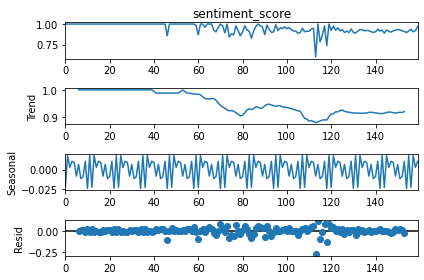

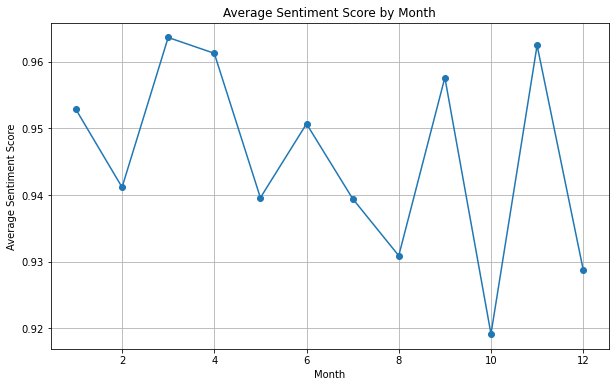

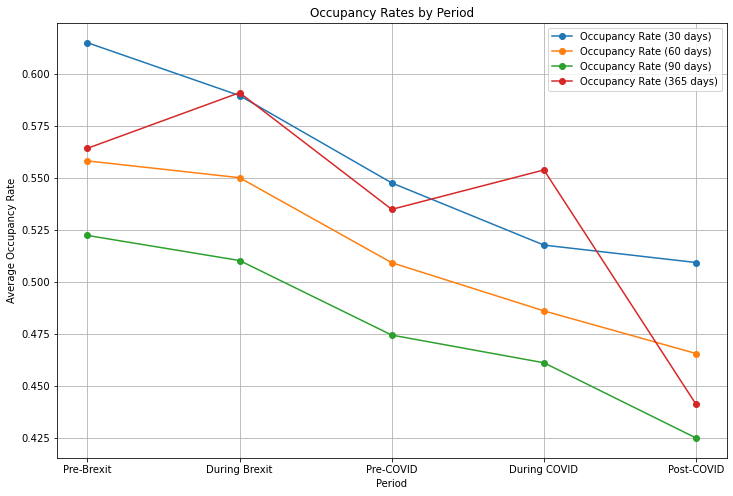

In [60]:
# Ensure there are no missing values in sentiment_monthly
sentiment_monthly['sentiment_score'].fillna(method='ffill', inplace=True)

# Decompose the time series for sentiment scores
result = seasonal_decompose(sentiment_monthly['sentiment_score'], model='additive', period=12)

# Plot the decomposition results
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# Add a 'month' column to the data
merged_data['month'] = merged_data['date'].dt.month

# Group by month and calculate the mean sentiment score
monthly_sentiment = merged_data.groupby('month')['sentiment_score'].mean().reset_index()

# Ensure there are no missing values in monthly_sentiment
monthly_sentiment['sentiment_score'] = monthly_sentiment['sentiment_score'].ffill().bfill()

# Plot the average sentiment score by month using Matplotlib directly
plt.figure(figsize=(10, 6))
plt.plot(monthly_sentiment['month'].values, monthly_sentiment['sentiment_score'].values, marker='o')
plt.title('Average Sentiment Score by Month')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

# Event Impact Analysis

# Define the periods of interest
periods = {
    "Pre-Brexit": (merged_data['date'].min(), '2015-01'),
    "During Brexit": ('2015-01', '2016-06'),
    "Pre-COVID": ('2016-07', '2020-02'),
    "During COVID": ('2020-02', '2021-06'),
    "Post-COVID": ('2021-06', merged_data['date'].max())
}

# Assign period to each date
def assign_period(date):
    for period, (start, end) in periods.items():
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return period
    return 'unknown'

merged_data['period'] = merged_data['date'].apply(assign_period)

# Group by period and calculate mean occupancy rates
period_occupancy = merged_data.groupby('period')[['occupancy_rate_30', 'occupancy_rate_60', 'occupancy_rate_90', 'occupancy_rate_365']].mean().reset_index()

# Ensure there are no infinities or NaNs in the data
period_occupancy = period_occupancy.replace([np.inf, -np.inf], np.nan).dropna()

# Reorder periods to ensure correct chronological order
period_order = ["Pre-Brexit", "During Brexit", "Pre-COVID", "During COVID", "Post-COVID"]
period_occupancy['period'] = pd.Categorical(period_occupancy['period'], categories=period_order, ordered=True)
period_occupancy = period_occupancy.sort_values('period')

# Convert period_occupancy columns to numpy arrays for plotting
periods = period_occupancy['period'].values
occupancy_rate_30 = period_occupancy['occupancy_rate_30'].values
occupancy_rate_60 = period_occupancy['occupancy_rate_60'].values
occupancy_rate_90 = period_occupancy['occupancy_rate_90'].values
occupancy_rate_365 = period_occupancy['occupancy_rate_365'].values

# Plot the occupancy rates by period using Matplotlib directly
plt.figure(figsize=(12, 8))
plt.plot(periods, occupancy_rate_30, marker='o', label='Occupancy Rate (30 days)')
plt.plot(periods, occupancy_rate_60, marker='o', label='Occupancy Rate (60 days)')
plt.plot(periods, occupancy_rate_90, marker='o', label='Occupancy Rate (90 days)')
plt.plot(periods, occupancy_rate_365, marker='o', label='Occupancy Rate (365 days)')
plt.legend()
plt.title('Occupancy Rates by Period')
plt.xlabel('Period')
plt.ylabel('Average Occupancy Rate')
plt.grid(True)
plt.show()

### Interpretation of Results

**1. Seasonal Decomposition of Sentiment Scores**

The seasonal decomposition of sentiment scores provides insights into different components that affect the overall sentiment over time:

- Trend Component: This shows a gradual decline in sentiment scores over the period analyzed. The trend appears to dip more significantly around periods of notable events such as Brexit and the COVID-19 pandemic, indicating that these events may have had a negative impact on overall sentiment.

- Seasonal Component: The seasonal component reveals periodic fluctuations in sentiment scores. This indicates that sentiment changes follow a recurring pattern each year. However, the fluctuations are relatively small compared to the overall trend.

- Residual Component: The residuals show the irregular component or noise after removing the trend and seasonal effects. The residuals are fairly distributed around zero, suggesting that the decomposition has effectively captured the main patterns.

**2. Occupancy Rates by Period**

The analysis of occupancy rates by different periods (Pre-Brexit, During Brexit, Pre-COVID, During COVID, Post-COVID) shows the following patterns:

- Pre-Brexit and During Brexit: Occupancy rates were relatively stable with slight fluctuations. During Brexit, there is a noticeable decrease, especially in the occupancy rate over longer periods (90 and 365 days), indicating a potential impact of political uncertainty on long-term stays.

- Pre-COVID: A decline in occupancy rates is observed leading up to the COVID-19 pandemic. This decline could be attributed to increasing global awareness and early impacts of the pandemic.

- During COVID: There is a sharp decline in all occupancy rates, reflecting the severe impact of the pandemic on travel and short-term rentals. The occupancy rates for 30, 60, 90, and 365 days all hit their lowest points during this period.

- Post-COVID: The occupancy rates show a recovery trend post-COVID, with all rates bouncing back. The most significant recovery is observed in the shorter-term occupancy rates (30 and 60 days), suggesting that short-term rentals were quicker to recover compared to longer-term stays.

**Summary** 

- Seasonal Decomposition: The trend component shows a general decline in sentiment scores, with notable dips around major events like Brexit and COVID-19. The seasonal component indicates small but recurring annual patterns.

- Occupancy Rates: Occupancy rates declined during Brexit and dropped significantly during COVID-19. Post-COVID recovery is visible, especially in short-term occupancy rates, suggesting a quicker rebound in short-term rentals compared to longer-term stays.